In [1]:
import figures
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
paths = [
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-chat-gptq_temp_0.2_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-chat-gptq_temp_0.6_topp_0.9_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-chat-gptq_temp_0.6_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-chat-gptq_temp_1.0_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-chat-gptq_temp_5.0_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-gptq_temp_0.2_topp_1.0_targetonly_2024_01_17.pkl', 
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-gptq_temp_0.6_topp_0.9_targetonly_2024_01_17.pkl', 
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-gptq_temp_0.6_topp_1.0_targetonly_2024_01_17.pkl', 
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-gptq_temp_1.0_topp_1.0_targetonly_2024_01_17.pkl', 
    '/var/cr06_data/avner/results/spec_decoding/final/eval_llama_wikitext_target_llama-2-70b-gptq_temp_5.0_topp_1.0_targetonly_2024_01_17.pkl', 
    '/var/cr06_data/avner/results/spec_decoding/final/eval_pythia_wikitext_target_pythia-12b_temp_0.2_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_pythia_wikitext_target_pythia-12b_temp_0.6_topp_0.9_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_pythia_wikitext_target_pythia-12b_temp_0.6_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_pythia_wikitext_target_pythia-12b_temp_1.0_topp_1.0_targetonly_2024_01_17.pkl',
    '/var/cr06_data/avner/results/spec_decoding/final/eval_pythia_wikitext_target_pythia-12b_temp_5.0_topp_1.0_targetonly_2024_01_17.pkl',
]
dfs = []
for path in paths:
  dfs.append(pd.read_pickle(path))
df = pd.concat(dfs)

In [8]:
# These are the alphas for Llama-70b/Llama-7b, measured by Zhuoming.
# alphas_7b_70b = np.array([
#     0.0, 0.8480, 8.6126e-02, 2.7199e-02, 1.1198e-02, 6.2547e-03, 4.0326e-03, 2.9872e-03,
#     1.9144e-03, 1.5849e-03, 1.5069e-03, 9.6941e-04, 7.7558e-04, 5.2512e-04,
#     7.0280e-04, 4.2999e-04, 3.3933e-04, 5.3316e-04, 4.8459e-05, 4.3625e-04,
#     3.3927e-04, 1.9389e-04, 1.4544e-04, 1.4544e-04, 1.2118e-04, 1.9383e-04,
#     0.0000e+00, 1.8549e-04, 1.4538e-04, 9.6977e-05, 9.6917e-05, 9.6977e-05,
#     1.9383e-04,
# ])
# alphas = np.cumsum(alphas_7b_70b)

In [4]:
drafts = [
    'EleutherAI/pythia-410m',
    'EleutherAI/pythia-1b',
    'EleutherAI/pythia-2.8b',
    'JackFram/llama-160m',
    'princeton-nlp/Sheared-LLaMA-1.3B-ShareGPT',
]
temps = [
    0.2, 0.6, 1.0, # 5.0
]
max_budget = 10**4
max_branch_width = 32
results = {}
for draft in drafts:
  for temp in temps:
    alphas = figures.get_alphas(df, draft=draft, metric='specinfer_acceptance_no_replace_k', temp=temp, top_p=1.0)
    sequoia, _ = figures.best_tree_unbalanced(
        alphas, max_branch_width=max_branch_width, max_budget=max_budget, verbose=False)
    single_chain, independent_chains, k_tree = figures.baselines(
        alphas, max_budget=max_budget, max_branch_width=max_branch_width, )
    results[f'{draft}_{temp}'] = (single_chain, independent_chains, k_tree, sequoia)

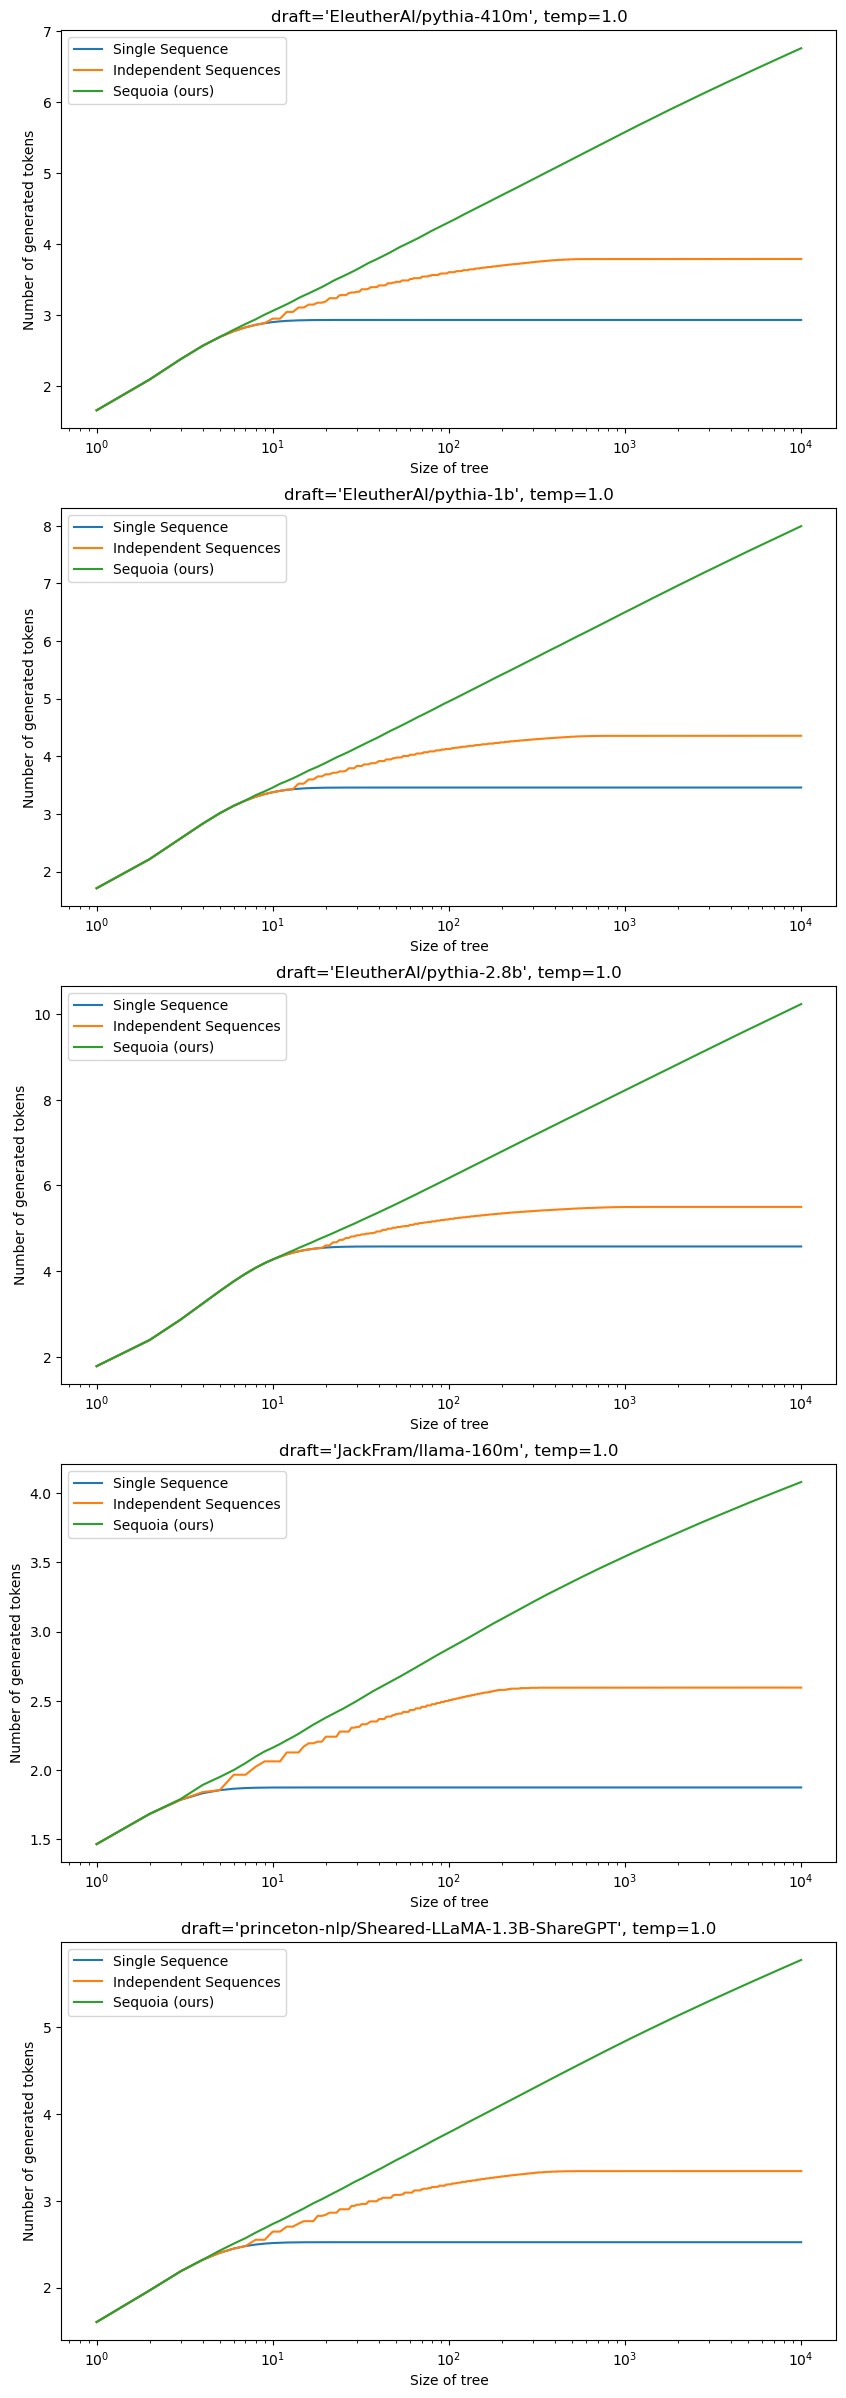

In [8]:
temp = 1.0
plt.figure(figsize=(10, 30))
for i, draft in enumerate(drafts):
  plt.subplot(len(drafts), 1, i + 1)
  single_chain, independent_chains, k_tree, sequoia = results[f'{draft}_{temp}']
  plt.plot(np.arange(1, len(single_chain) + 1), single_chain, label='Single Sequence')
  plt.plot(np.arange(1, len(independent_chains) + 1), independent_chains, label='Independent Sequences')
  plt.plot(np.arange(1, len(sequoia) - 1), sequoia[2:], label='Sequoia (ours)')
  # plt.plot(np.arange(1, len(k_tree[0, :]) + 1), k_tree[0, :], label='Binary tree')
  plt.xscale('log')
  plt.xlabel('Size of tree')
  plt.ylabel('Number of generated tokens')
  plt.title(f'{draft=}, {temp=}')
  plt.plot()
  plt.legend()
